---
title: "Check In 2"
format: 
  html: 
    embed-resources: true
    self-contained-math: true
---

## Scraping
I have scraped the data in a seperate script. I have included it here commented out so it is visible how I did it but there's no need to rerun it of course. I have elected to use Steam data from user reviews. I am interested in comparing trends between reviews of games that have female protagonists versus games with male protagonists. Finding games with female protagonists was the hardest part, so I selected {list}. Then I selected games with male protagonists that I tried to map 1 to 1 with the female protagonist games (same year ± 1, similar genre, etc.) as these are likely to be potentially confounding variables in comparison.The question I am attempting to answer is "Does review content differ depending on whether the lead protagonist of a video game is female or not?"

In [1]:
%%capture
"""
import requests
import urllib.parse
from time import sleep
import os
from dotenv import load_dotenv
from urllib.parse import quote
import pickle
import re

load_dotenv()

KEY = os.getenv('KEY')

def getUserReviews(reviewAppid, params):
    #userReviewsUrl = f'https://store.steampowered.com/appreviews/{reviewAppid}'
    cursor = params['cursor']
    userReviewsUrl = f"https://store.steampowered.com/appreviews/{reviewAppid}?json=1&cursor={cursor}&filter_offtopic_activity=0&filter=recent&language=english&num_per_page=100"
    userReviewsResponse = requests.get(
            userReviewsUrl,
            #params=params
        )
    print(f"Status Code: {userReviewsResponse.status_code}")
    

    if (userReviewsResponse.status_code != 200) and (userReviewsResponse.status_code != 429):
        print(f'Fail to get response for {reviewAppid}. Status code: {userReviewsResponse.status_code}')
        return {'success' : 0}, userReviewsResponse.status_code
    try:
        userReviews = userReviewsResponse.json()
    except:
        return {"success": 0}, userReviewsResponse.status_code
    return userReviews, userReviewsResponse.status_code

gamesOfInterestFemale = {
    '870780' : 'Control Ultimate Edition',
    '752590' : 'A Plague Tale Innocence',
    '750920' : 'Shadow of the Tomb Raider',
    '414340' : "Hellblade: Senua's Sacrifice",
    '524220' : 'Nier:Automata',
    '1265920' : 'Life is Strange Remastered',
}

gamesOfInterestMale = {
    '108710' : 'Alan Wake',
    '532210' : 'Life is Strange 2',
    '1659420' : 'Uncharted: Legacy of Thieves Collection',
    '814380' : 'Sekiro: Shadows Die Twice - GOTY Edition',
    '1687950' : 'Persona 5 Royal',
    '2050650' : 'Resident Evil 4'
}

allGamesOfInterest = {
    'female' : gamesOfInterestFemale,
    'male' : gamesOfInterestMale    
}

def parseResponse(gameId, gameTitle):
    reviewsSkipped = 0
    reviews = []
    name = gameTitle
    reviewMax = 100
    #reviewMax = 20
    params = {
            #'json' : 1,
            #'language' : 'english',
            'cursor' : '*',
            #'filter_offtopic_activity' : 1,
            #'num_per_page': 100,
            #'key' : KEY,
            #'filter' : 'recent'
    }
    while(True):
        reviewMin = reviewMax - 100
        #reviewMin = reviewMax - 20
        print(f"Getting Reviews: {reviewMin}-{reviewMax} for {name}")
        print(f"Params: {params}")
        response,status = getUserReviews(gameId,params)
        if status == 429:
            print(f"Rate Limiting")
            sleep(300)
            continue
        print(f"Extracted {len(response['reviews'])} reviews")
        #print(response['reviews'])
        #if response['success'] != 1:
        #    print(f'Fail to get response for {gameId}.')
        #    return {'allReviewsGot' : 0}, []

        for review in response['reviews']:
            try:
                recommendationId = review['recommendationid']

                timestampCreated = review['timestamp_created']
                timestampUpdated = review['timestamp_updated']

                authorSteamId = review['author']['steamid']
                playtimeForever = review['author']['playtime_forever']
                playtimeLastTwoWeeks = review['author']['playtime_last_two_weeks']
                playtimeAtReviewMinutes = review['author']['playtime_at_review']
                lastPlayed = review['author']['last_played']

                reviewText = review['review']
                votedUp = review['voted_up']
                votesUp = review['votes_up']
                votesFunny = review['votes_funny']
                weightedVoteScore = review['weighted_vote_score']
                steamPurchase = review['steam_purchase']
                receivedForFree = review['received_for_free']
                writtenDuringEarlyAccess = review['written_during_early_access']

                myReviewDict = {
                    'recommendationid': recommendationId,
                    'authorSteamid': authorSteamId,
                    'playtimeAtReviewMinutes': playtimeAtReviewMinutes,
                    'playtimeForeverMinutes': playtimeForever,
                    'playtimeLastTwoWeeksMinutes': playtimeLastTwoWeeks,
                    'lastPlayed': lastPlayed,

                    'reviewText': reviewText,
                    'timestampCreated': timestampCreated,
                    'timestampUpdated': timestampUpdated,

                    'votedUp': votedUp,
                    'votesUp': votesUp,
                    'votesFunny': votesFunny,
                    'weightedVoteScore': weightedVoteScore,
                    'steamPurchase': steamPurchase,
                    'receivedForFree': receivedForFree,
                    'writtenDuringEarlyAccess': writtenDuringEarlyAccess,
                }
                reviews.append(myReviewDict)
            except:
                print("Skipped Review")
                reviewsSkipped += 1
                print(f'Reviews Skipped: {reviewsSkipped}')
        if response['cursor'] == params['cursor']:
            return reviews
        
        if response['query_summary']['num_reviews'] == 0:
            print(f'No more reviews: {response}')
            return reviews
        
        try:
            cursor = response['cursor']
            print(cursor)
            params['cursor'] = quote(cursor)
            print(params['cursor'])
        except:
            return reviews
        
        reviewMax += 100
        #reviewMax += 20
        sleep(1.5)



steamIDs = ['870780','752590','750920','414340','524220','1265920','108710','532210','1659420','814380','1687950','2050650']

for key,items in allGamesOfInterest.items():
        for key,val in items.items():
            reviews = parseResponse(key,val)
            title = val.strip().replace(" ","_").lower()
            titleClean = re.sub(r'[^\w_. -]', '_', title)
            data = {key : reviews}
            with open(f'./data/pkl/{titleClean}.pkl','wb') as f:
                pickle.dump(data,f)
            try:
                steamIDs.remove(key)
                print(f"{len(steamIDs)} games left")
            except:
                print("Crying is a free action")
"""

## Cleaning
Due to the nature of steam being a place of informal reviews, a lot of text cleaning has to be done to the reviews which ultimately does reduce the amount of data but the data available is relatively clean. I have commented out my process but it is essentially: 
load -> remove excess scraped data -> remove reviews missing elements to filter by -> filter by playtime >3hrs and within two week palytime of review writing >15 mins -> remove emoji and extra whitespace -> remove links -> clear out non enlish reviews (apparently steam language tags aren't very good)

In [2]:
import pickle
import re
from collections import Counter
from lingua import Language, LanguageDetectorBuilder
import numpy as np

In [3]:
np.random.seed(69)

def load(file):
    with open(file,'rb') as f:
        return pickle.load(f)

def extractData(review):
    recId = review['recommendationid']
    reviewPlaytime = review['playtimeAtReviewMinutes']
    earlyAccessReview = review['writtenDuringEarlyAccess']
    votedUp = review['votedUp']
    helpfulness = review['weightedVoteScore']
    recentPlaytime = review['playtimeLastTwoWeeksMinutes']
    
    text = review['reviewText']
    
    trimmedData = {
        'id' : recId,
        'playtime' : reviewPlaytime,
        'recentPlaytime' : recentPlaytime,
        'earlyAccess' : earlyAccessReview,
        'votedUp' : votedUp,
        'helpfulness' : helpfulness
    }
    
    return trimmedData, text

def isEnglish(string):
  return string.isascii()

def cleanData(reviews):
    languages = [Language.ENGLISH, Language.SPANISH, Language.PORTUGUESE]
    detector = LanguageDetectorBuilder.from_languages(*languages).build()
    outReviews = []
    for review in reviews:
        data, text = extractData(review)
        if (data['playtime'] == None) or (data['recentPlaytime'] == None):
            continue
        elif (int(data['playtime']) >= 180) and (int(data['recentPlaytime']) >= 15):
            #Removes emoji like characters
            normText = re.sub(r"[^\w\s\.,!?;:\(\)\[\]\-\+=\{\}\|\/\<\>.]", '', text)
            #Remove links
            cleanText = re.sub(r"\[.*?\]|(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])", '', normText)
            #Remove excess whitespace
            cleanText = ' '.join(cleanText.split())
            #Remove reviews that follow a specific pattern that results in odd text
            if bool(re.search('---.*?---', cleanText)):
                continue
            #Check if string is ascii encoded
            elif isEnglish(cleanText):
                #Ignore reviews with less than 5 words
                if sum(Counter(cleanText.split()).values()) < 5:
                    continue
                #Make sure review is in english
                elif detector.detect_language_of(cleanText) != Language.ENGLISH:
                    continue
                else:
                    outReviews.append([data, cleanText])
    return outReviews

## Preprocessing
Now we can finally do some nlp preprocessing using spaCy and generate plots and data using Wordcloud and Gensim

Data structure for the preprocessed data is a dictionary of reviews, where the first 6 are female protagonists and the last 6 are male protagonists. Each dictionary entry is a list of reviews which themselves are lists. The first value is a dictionary of values for the review data, and the second value is the review text.

Note I haven't done any lemmatization or punctuation removal yet since I'm not exactly sure what methods I'll be using fyet (hopefully LDA, Topic Modeling, and Sentiment Analysis) so I don't want to store that yet. I also have the ability to make tables with lemma, POS, etc. but didn't want to include a lot of those graphs considering the individual unit is really probably going to be reviews and negative and positive review types maybe important. The word clouds warrant further exploration since obviously "game" is one of the most prevalent words.

Since the last blog post, I know have changed the way I count words, and now remove the top 20 most common words for the wordclouds, excluding the top 20 most common words. I also discovered that the rats appearing twice is a function argument which involves some sort of two word phrasing or covariance.

In [4]:
control = load("data/pkl/control_ultimate_edition.pkl")['870780']
plagueTale = load("data/pkl/a_plague_tale_innocence.pkl")['752590'] 
tombRaider = load("data/pkl/shadow_of_the_tomb_raider.pkl")['750920'] 
senuaSacrifice = load("data/pkl/hellblade__senua_s_sacrifice.pkl")['414340']
nierAutomata = load("data/pkl/nier_automata.pkl")['524220'] 
lifeIsStrangeRem = load("data/pkl/life_is_strange_remastered.pkl")['1265920'] 

re4 = load("data/pkl/resident_evil_4.pkl")['2050650']
alanWake = load("data/pkl/alan_wake.pkl")['108710']
lifeIsStrange2 = load("data/pkl/life_is_strange_2.pkl")['532210'] 
uncharted = load("data/pkl/uncharted__legacy_of_thieves_collection.pkl")['1659420']
sekiro = load("data/pkl/sekiro__shadows_die_twice_-_goty_edition.pkl")['814380'] 
persona5 = load("data/pkl/persona_5_royal.pkl")['1687950']  

In [5]:
femaleGamesNames = ['control', 'plagueTale', 'tombRaider', 'senuaSacrifice', 'nierAutomata', 'lifeIsStrangeRem']
maleGamesNames = ['re4', 'alanWake', 'lifeIsStrange2', 'uncharted', 'sekiro', 'persona5']

allGamesKeys = femaleGamesNames + maleGamesNames
allGameObj = [control, plagueTale, tombRaider, senuaSacrifice, nierAutomata, lifeIsStrangeRem, re4, alanWake, lifeIsStrange2, uncharted, sekiro, persona5]
allGamesClean = [cleanData(x) for x in allGameObj]

allGamesClean = {key: value for key, value in zip(allGamesKeys, allGamesClean)}

In [6]:
allGamesClean.keys()

dict_keys(['control', 'plagueTale', 'tombRaider', 'senuaSacrifice', 'nierAutomata', 'lifeIsStrangeRem', 're4', 'alanWake', 'lifeIsStrange2', 'uncharted', 'sekiro', 'persona5'])

In [7]:
#mport nltk
#nltk.download()

In [8]:
%%capture
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from spacy import load
from spacy.tokens import Doc, DocBin
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English, stop_words

from wordcloud import WordCloud

import matplotlib.pyplot as plt
import seaborn as sns
nlp = load("en_core_web_sm")


newWords = {
    'resident': 0.0, 
    'evil': 0.0, 
    'tomb': 0.0,
    'raider': 0.0,
    'control' : 0.0,
    'plague' : 0.0,
    }

sia = SentimentIntensityAnalyzer()

sia.lexicon.update(newWords)

In [9]:
# for key,reviews in allGamesClean.items():
#     #allText = ""
#     docBin = DocBin()
#     for review in reviews:
#         doc = nlp(review[1])
#         doc.user_data = review[0]
#         print(doc.text.lower())

control usable reviews: 242
{'omg': 1, 'love': 28, 'finland': 1, 'hot': 1, 'ill': 4, '5': 10, '10/10': 13, 'overall': 11, 'starting': 1, 'cons': 3, 'map': 13, 'design': 14, 'directions': 2, 'crap': 2, 'look': 6, 'videos': 2, 'lost': 5, 'rest': 3, 'vibe': 5, '8/10': 2, 'visuals': 8, '11/10': 2, 'puzzles': 3, 'simple': 10, 'ran': 3, 'dx': 1, '12': 1, 'mode': 7, 'amd': 2, '5600x': 1, '6900xt': 1, 'windows': 1, '10': 7, 'ultra': 2, 'rtx': 5, '60fps': 1, '100fps': 1, 'looking': 5, 'friend': 1, 'referred': 1, '100': 4, 'percent': 1, 'satisfied': 1, 'experience': 13, 'gave': 1, 'pay': 3, 'attention': 8, 'surroundings': 1, 'secrets': 4, 'nice': 6, 'playability': 1, 'graphics': 25, 'entertained': 2, 'weeks': 2, 'little': 20, 'buggy': 1, 'glitches': 1, 'menu': 1, 'screens': 1, 'eventual': 1, 'freeze': 1, 'eventually': 3, 'goes': 2, 'dark': 2, 'outlines': 1, 'items': 5, 'phases': 1, 'objective': 1, 'location': 1, 'guess': 3, 'searching': 1, 'hidden': 6, 'huge': 8, 'apart': 2, 'lately': 1, 'bit': 

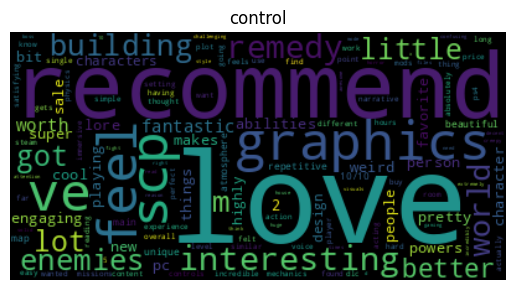

plagueTale usable reviews: 58
{'10/10': 6, 'luckily': 1, 'sequel': 4, 'jump': 1, 'nice': 6, 'amazing': 4, 'definitely': 5, 'par': 1, 'written': 1, 'controls': 1, 'tab': 1, 'bit': 3, 'funky': 1, 'action': 1, 'means': 2, 'love': 6, 'flow': 1, 'horror': 1, 'inducing': 1, 'think': 4, 'preview': 1, 'screenshots': 1, 'justice': 1, 'central': 1, 'thing': 5, 'pretty': 5, 'neat': 2, 'puzzle': 1, 'system': 2, 'visual': 2, 'expect': 1, 'suspend': 1, 'disbelief': 1, 'vast': 1, 'majority': 1, 'playthrough': 2, 'ykno': 1, 'aware': 1, 'gon': 1, 'na': 1, 'close': 1, 'historically': 1, 'accurate': 1, 'tho': 2, 'relatively': 1, 'world': 5, 'interesting': 6, 'felt': 7, 'mediocre': 1, 'enjoyed': 2, 'half': 1, 'way': 5, 'predictable': 1, 'kind': 1, 'weird': 1, 'taste': 1, 'tries': 2, 'balance': 1, 'fantasy': 2, 'gritty': 1, 'realism': 1, 'falls': 2, 'flat': 2, 'overall': 7, 'time': 6, 'prepare': 1, 'die': 1, 'frustrated': 1, 'npc': 1, 'pathing': 1, 'stealth': 4, '11/17': 1, 'chapters': 1, 'completed': 2, '

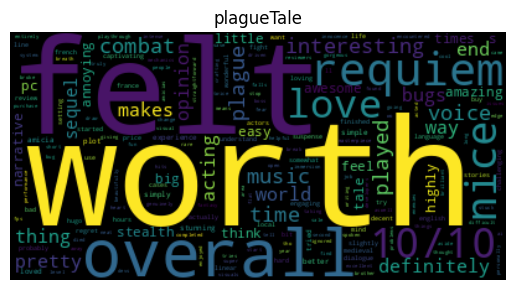

tombRaider usable reviews: 181
{'playthrough': 5, 'review': 7, 'final': 5, 'trilogy': 25, 'previous': 22, 'likely': 1, 'find': 12, 'installment': 4, 'appealing': 1, 'nice': 22, 'environments': 6, 'engaging': 6, 'gameplay': 29, 'introduces': 2, 'new': 24, 'features': 10, 'purchase': 1, 'definitive': 1, 'edition': 3, 'includes': 1, 'seven': 1, 'additional': 4, 'access': 2, 'missions': 16, 'separately': 1, 'main': 11, 'menu': 2, 'completing': 1, 'adds': 4, 'dlc': 8, 'overall': 12, 'plot': 5, 'exploration': 23, 'challenging': 7, 'enjoyed': 12, 'times': 10, 'annoyed': 3, 'absolute': 2, 'worst': 3, 'sure': 7, 'perfect': 6, 'mechanics': 11, 'fine': 4, 'reason': 9, 'changed': 2, 'key': 5, 'binds': 1, 'incredibly': 1, 'mid': 2, 'want': 13, 'finish': 4, 've': 21, 'genuinely': 2, 'bored': 4, 'characters': 12, 'feel': 24, 'flawed': 1, '2': 14, 'feels': 18, 'rushed': 2, 'ran': 1, 'ideas': 2, 'general': 7, 'ahead': 1, 'boring': 12, 'suggest': 1, 'death': 6, 'scene': 3, 'child': 2, 'beaucoup': 2, 'tr

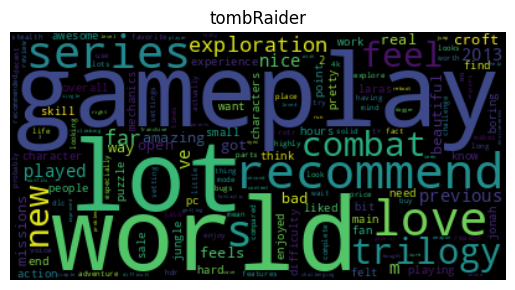

senuaSacrifice usable reviews: 72
{'sacrifice': 5, 'unique': 4, 'style': 3, 'similar': 3, 'couple': 1, 'classics': 1, 'aswell': 1, 'd': 4, 'compare': 1, 'tomb': 2, 'raider': 2, 'mixed': 1, 'elden': 1, 'ring': 1, 'souls': 3, 'games': 11, 'forgiving': 1, 'usual': 1, 'mini': 1, 'boss': 11, 'battles': 3, 'brilliant': 1, 'aspect': 2, 'definitely': 6, 'sound': 10, 'design': 8, 'revealing': 1, 'incredibly': 3, 'immersive': 6, 'silly': 1, 'thing': 5, 'rave': 1, 'playing': 10, 'understand': 1, 'mean': 1, 'protagonist': 3, 'constant': 1, 'slurry': 1, 'narration': 3, 'voices': 7, 'whispers': 2, 'trapped': 1, 'head': 6, 'deepening': 1, 'characters': 5, 'thoughts': 4, 'concerns': 1, 'explores': 1, 'point': 5, 'view': 1, 'severe': 1, 'illness': 3, 'schizophrenia': 1, 'split': 1, 'personality': 3, 'syndrome': 1, 'strongly': 1, 'fairly': 2, 'short': 7, 'hours': 10, 'accurate': 1, 'left': 3, 'open': 2, 'hour': 2, 'bit': 7, 'lasts': 1, '6': 1, 'grab': 1, 'sale': 2, 'cd': 1, 'keys': 1, 'price': 2, 'love'

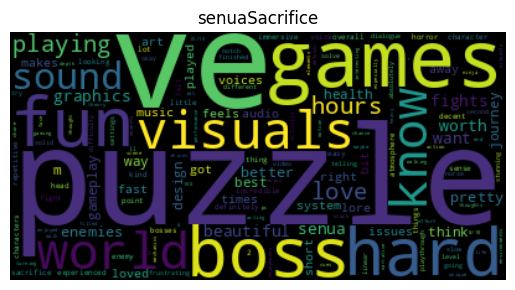

nierAutomata usable reviews: 300
{'traumatized': 1, 'literally': 2, 'gripping': 1, 'ass': 12, 'monitor': 2, 'cutscenes': 3, '10/10': 34, 'fun': 34, 'sure': 10, 'choices': 3, 'soundtrack': 25, 'amazing': 35, 'plot': 13, 'came': 12, 'android': 9, 'ladies': 1, 'left': 11, 'emotionally': 3, 'shattered': 1, 'contemplating': 1, 'life': 22, 'perfect': 9, 'got': 26, 'flaws': 2, 'enjoyed': 7, '27': 2, 'endings': 26, 'achievements': 6, 'sacrifice': 3, 'save': 12, 'file': 1, 'help': 9, 'yeah': 10, 'oh': 8, 'boy': 3, 'tough': 1, 'd': 16, 'mixed': 1, 'positive': 2, 'review': 6, 'considered': 1, 'classic': 3, 'action': 14, 'genre': 6, 'directed': 3, 'auteur': 1, 'yoko': 11, 'taro': 10, 'hard': 15, 'criticize': 1, 'coming': 5, 'contrarian': 1, 'angry': 2, 'weirdo': 1, 'm': 37, 'going': 9, 'start': 11, 'thing': 15, 'character': 30, 'animations': 6, 'control': 3, '2b': 32, '9s': 17, 'a2': 11, 'designed': 2, 'visually': 2, 'incredibly': 4, 'detailed': 1, 'combat': 36, 'feel': 21, 'nice': 15, 'heavy': 4,

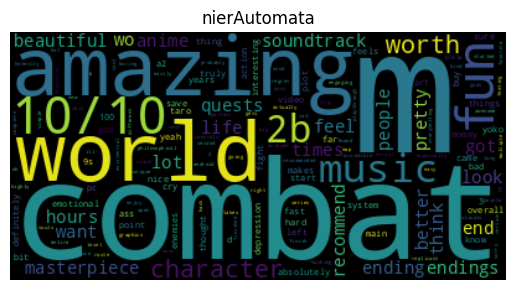

lifeIsStrangeRem usable reviews: 67
{'tl;dr': 1, 'buy': 5, 'unnecessary': 1, 'deliver': 1, 'quality': 1, 'm': 5, 'described': 1, 'hardcore': 1, 'lis': 2, 'fan': 3, 'beginning': 1, 'patiently': 1, 'waiting': 1, 'single': 2, 'episode': 3, 'release': 4, 'ip': 1, 'high': 1, 'hopes': 1, 'newest': 1, 'addition': 2, 'roster': 1, 'comes': 2, 'upcoming': 2, 'double': 1, 'exposure': 1, 'absolutely': 1, 'recommend': 7, 'booted': 1, 'loved': 4, 'new': 4, 'shiny': 1, 'feel': 5, 'updates': 1, 'character': 3, 'animations': 3, 'expressions': 1, 'kept': 1, 'general': 1, 'feeling': 1, 'start': 1, 'e2': 1, 'ongoing': 1, 'frustration': 1, 'quickly': 1, 'accumulated': 1, 'bugs': 8, 'key': 2, 'systems': 1, 'interaction': 1, 'prompts': 2, 'lighting': 4, 'outfit': 1, 'changes': 2, 'happen': 2, 'clear': 2, 'easily': 1, 'able': 2, 'miss': 1, 'details': 1, 'known': 1, 'know': 1, 'look': 3, 'number': 1, 'issues': 6, 'reported': 1, 'community': 1, 'forum': 1, 'staggering': 1, 'years': 7, 'dedicated': 1, 'squashing

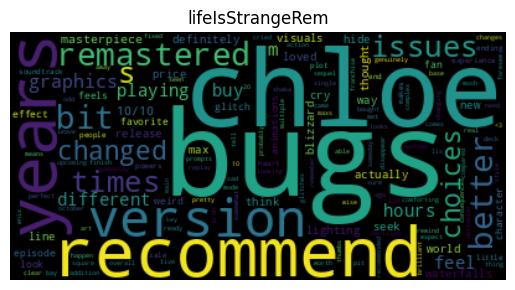

re4 usable reviews: 234
{'course': 4, '9,5/10': 1, 'buy': 12, 'action': 16, '2': 7, 'nice': 5, 'difference': 2, 'come': 3, 'enjoy': 11, 'killing': 2, 'pragas': 1, 'perfect': 16, 'finally': 2, '100': 4, 've': 15, 'got': 18, 'ta': 3, 'easily': 2, 'upgraded': 4, 'graphics': 16, 'eerie': 1, 'environments': 1, 'pulled': 2, 'smoother': 2, 'boss': 5, 'fight': 9, 'edge': 2, 'beating': 3, 'insanely': 1, 'satisfying': 3, 'loved': 9, 'mix': 2, 'tension': 4, 'exploration': 1, 'definitely': 6, 'favorite': 11, 'series': 8, '10/10': 18, 'worth': 8, 'money': 7, 'gave': 2, '9/10': 3, 'regenerador': 1, 'iron': 1, 'maiden': 1, 'verdugo': 1, 'cube': 1, 'version': 6, 'kid': 2, 'prefer': 3, 'charm': 3, 'humor': 1, 'elements': 4, 'step': 1, 'gud': 1, 'gub': 4, 'kennedy': 5, 'killed': 1, 'salazar': 4, 'tap': 2, 'easy': 3, 'kizzy': 2, 'saddler': 2, '0': 1, 'gawd': 1, 'shi': 1, 'perfection': 4, 'saves': 3, 'day': 2, 'halfway': 1, 'story': 22, 'experience': 10, 'atmosphere': 4, 'levels': 2, 'enjoyed': 2, 'thorou

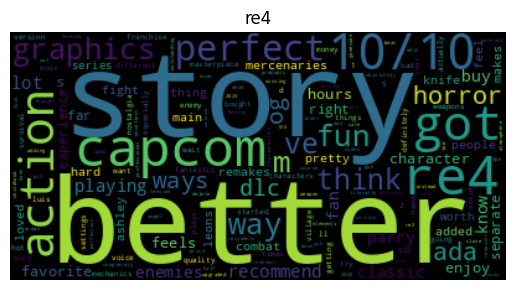

alanWake usable reviews: 49
{'wlan': 1, 'aake': 1, 'goobd': 1, 'emnjoyed': 1, '2/3': 1, 'pretty': 8, 'includes': 1, 'extra': 2, 'episodes': 3, 've': 7, 'gathered': 1, 'grew': 1, 'nice': 4, 'sheltered': 1, 'mamas': 1, 'stories': 3, 'furies': 1, 'mama': 1, 'gave': 3, 'magic': 1, 'clicker': 2, 'yes': 1, 'think': 2, 'true': 7, 'fair': 1, 'cmon': 1, 'listen': 2, 'lost': 5, 'words': 1, 'missing': 2, 'fire': 1, 'bearing': 1, 'eye': 3, 'drawn': 1, 'early': 1, 'dreams': 2, 'imagination': 1, 'nightmares': 2, 'night': 7, 'day': 4, 'yeah': 1, 'chased': 1, 'frights': 1, 'away': 6, 'knew': 1, 'clue': 1, 'hope': 1, 'remember': 3, 'visions': 1, 'come': 2, 'obeying': 1, 'switch': 2, 'champion': 4, 'ill': 4, 'herald': 4, 'ending': 5, 'diving': 4, 'deep': 5, 'surface': 4, 'crime': 1, 'chilling': 1, 'thrillers': 1, 'hard': 3, 'boiled': 1, 'killers': 1, 'best': 5, 'sellers': 1, 'award': 1, 'goes': 1, 'storys': 1, 'end': 4, 'piece': 1, 'fiction': 1, 'meaningless': 1, 'face': 1, 'creation': 1, 'meets': 1, 'm

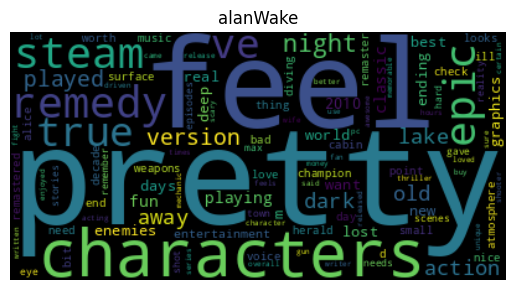

lifeIsStrange2 usable reviews: 44
{'overall': 5, 'okay': 2, 'worst': 3, 'series': 6, 'invested': 2, 'relationship': 3, 'brothers': 5, 'poor': 1, 'end': 6, 'lot': 6, 'interactions': 1, 'conversation': 1, 'forced': 2, 'consuming': 1, 'waiting': 2, 'new': 8, 'powerful': 1, 'sequel': 2, 'afraid': 3, 'stand': 3, 'feet': 2, 'spoiler': 1, 'free': 1, 'review': 2, 'sit': 2, 'write': 1, 'video': 3, 'usually': 2, 'best': 8, 'ignore': 1, 'external': 1, 'opinions': 1, 'possible': 2, 'truth': 2, 'told': 2, 'm': 8, 'easily': 3, 'influenced': 1, 'watching': 2, 'individual': 1, '1': 5, 'clips': 1, 'youtube': 1, 'title': 2, 'popped': 1, 's': 7, 'stuck': 2, 'head': 2, 'soulless': 3, 'lots': 1, 'things': 7, 'meandering': 1, 'times': 8, 'fairly': 2, 'boring': 4, 'furthest': 1, 'thing': 5, 'nod': 1, 'rehashed': 1, 'themes': 3, 'created': 1, 'appease': 1, 'originals': 1, 'fanbase': 1, 'implies': 1, 'emotionally': 2, 'genuine': 1, 'absolutely': 5, 'tackling': 1, 'entirely': 2, 'different': 5, 'completely': 1,

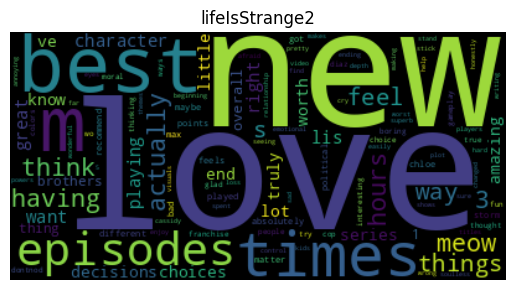

uncharted usable reviews: 29
{'designed': 1, 'indie': 1, 'styled': 1, 'characters': 3, 'try': 1, 'use': 1, 'stealth': 3, 'gunplay': 1, 'sooner': 1, 'later': 2, 'unforgiving': 2, 'additional': 1, 'note': 1, 'unlike': 1, 'new': 1, 'tomb': 3, 'raider': 3, 'motion': 1, 'sickness': 1, 'nathan': 1, 'drake': 1, 'handsome': 1, 'add': 2, 'unchatrted': 1, 'buy': 1, 'challanging': 1, 'puzzles': 3, 'combat': 3, 'assortment': 1, 'guns': 3, 'melee': 1, 'brawls': 1, 'brutal': 1, 'lots': 2, 'treasure': 2, '9/10': 1, 'glitches': 1, 'need': 3, 'patched': 1, 'probably': 2, 'breaking': 1, 'visual': 1, 'shooting': 2, 'mediocre': 1, 'apart': 1, 'old': 1, 'enjoyed': 2, 'goonies': 1, 'form': 1, 'free': 1, 'climbing': 4, '2016': 1, 'badge': 1, 'wrong': 1, 'point': 1, 'handhold': 1, 'wait': 1, 'animation': 1, 'confirmation': 1, 'click': 1, 'jump': 1, 's': 1, 'assume': 1, 'pad': 1, 'breaks': 1, 'immersion': 1, 'second': 2, 'lunge': 1, 'survive': 1, 'skin': 1, 'teeth': 1, '50th': 1, 'bit': 4, 'wooden': 1, 'horrib

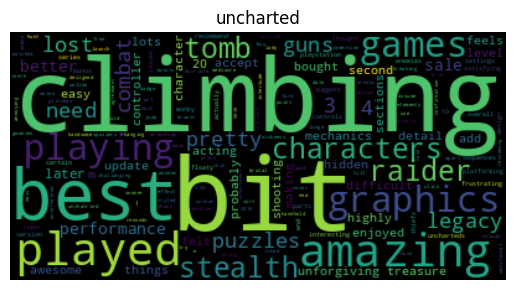

sekiro usable reviews: 910
{'mental': 4, 'health': 11, 'non': 4, 'existant': 1, 'believe': 2, 'twice': 85, 'finish': 11, 'yes': 8, 'mouse': 2, 'true': 18, 'ending': 16, 'ability': 7, 'finally': 18, 'uninstall': 2, 'recommend': 58, 'ragging': 1, 'torment': 1, 'pure': 5, 'masochists': 1, 'title': 14, 'lie': 6, 'forgot': 5, 'zeros': 1, 'shadows': 46, 'died': 26, '2000': 1, 'times': 48, 'accurate': 1, 'spelling': 1, 'mistake': 3, 'worth': 35, 'efford': 1, 'price': 6, 'bought': 7, 'stuck': 9, 'lady': 10, 'butterfly': 10, 'parry': 69, 'greatest': 12, 'system': 86, 'created': 2, 'dream': 3, 'large': 3, 'elden': 43, 'ring': 41, 'man': 14, 'sword': 37, 'arm': 2, 'liked': 1, 'rhythm': 8, 'battle': 16, 'attack': 33, 'patterns': 11, 'varied': 1, 'novel': 1, 'feel': 49, 'enjoyable': 10, 'expected': 2, 'frustratingly': 1, 'delivered': 1, 'thoroughly': 2, 'enjoyed': 9, 'emotional': 3, 'breakdown': 1, 'fighting': 30, 'genichiro': 28, 'ashina': 16, 'll': 21, 'soulsborne': 12, 'difficult': 48, 've': 85,

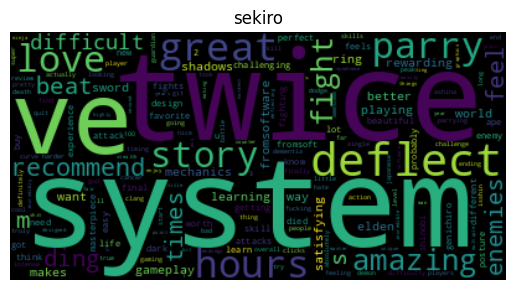

persona5 usable reviews: 0


In [10]:
def flatten(xss):
    return [x for xs in xss for x in xs]

def merge_counters(dict1, dict2):
    result = dict1.copy()
    for key, value in dict2.items():
        if key in result:
            result[key] += value
        else:
            result[key] = value
    return result

spacyStopWords = stop_words.STOP_WORDS

maleReviewBin = DocBin(store_user_data=True)
femaleReviewBin = DocBin(store_user_data=True)


for key,reviews in allGamesClean.items():
    allReviewCount = {}
    docBin = DocBin(store_user_data=True)
    for review in reviews:
        doc = nlp(review[1])
        doc.user_data = review[0]
        reviewtextCount = Counter([token.text.lower() for token in doc if not token.is_punct if not token.is_stop])
        allReviewCount = merge_counters(allReviewCount,reviewtextCount)
        docBin.add(doc)
    
    if key in femaleGamesNames:
        femaleReviewBin.merge(docBin)
    
    if key in maleGamesNames:
        maleReviewBin.merge(docBin)
       
    #Interestingly persona5 has no usable reviews! This will probably warrant looking at the underlying data to verify
    usableReviews = len(list(docBin.get_docs(nlp.vocab)))
    print(f"{key} usable reviews: {usableReviews}")
    if usableReviews > 0:
        mostCommonWords = dict(Counter(allReviewCount).most_common(20))
        wordsClean = {k:v for k,v in allReviewCount.items() if k not in mostCommonWords}
        #reviewContent = flatten(list(docBin.get_docs(nlp.vocab)))
        print(wordsClean)
        wordcloud = WordCloud(collocations=False).generate_from_frequencies(wordsClean)
        plt.figure()
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"{key}")
        plt.show()

In [11]:
print(f"Male Protagonist Reviews: {len(maleReviewBin)}")
print(f"Female Protagonist Reviews: {len(femaleReviewBin)}")

maleReviews = list(maleReviewBin.get_docs(nlp.vocab))
femaleReviews = list(femaleReviewBin.get_docs(nlp.vocab))

def sort_review_type(docs, key, val):
    reviewOut = []
    sumVal = 0
    for doc in docs:
        if doc.user_data[key] == val:
            sumVal += 1
            reviewOut.append(doc)
    return sumVal, reviewOut

numMaleNeg, maleNeg = sort_review_type(maleReviews, 'votedUp', False)
numMalePos, malePos = sort_review_type(maleReviews, 'votedUp', True)
numFemaleNeg, femaleNeg = sort_review_type(femaleReviews, 'votedUp', False)
numFemalePos, femalePos = sort_review_type(femaleReviews, 'votedUp', True)

print(f"Male Protagonist Negative Reviews: {numMaleNeg}")
print(f"Male Protagonist Positive Reviews: {numMalePos}")
print(f"Male Protagonist Negative Reviews: {numFemaleNeg}")
print(f"Male Protagonist Positive Reviews: {numFemalePos}")

Male Protagonist Reviews: 1266
Female Protagonist Reviews: 920
Male Protagonist Negative Reviews: 48
Male Protagonist Positive Reviews: 1218
Male Protagonist Negative Reviews: 57
Male Protagonist Positive Reviews: 863


In [12]:
#Lets make a single chart comparing male to female game review content. 
#TODO
def doclist_wordcount(doclist):
    counts = {}
    for doc in doclist:
        docCount = Counter([token.text.lower() for token in doc if not token.is_punct if not token.is_stop])
        merge_counters(counts,docCount)

## Sentiment Analysis
Conveniently the data is already self seperated into positive and negative reviews. This makes sentiment analysis comparison and possibly machine learning easy (although as we can see we have very unbalanced datasets and overall a gnereally small dataset to begin with). Libraries that work with spacy don't easily allow manipulation of sentiment dictionaries so I've just elected to use NLTK for this specifically. It's not perfectly consistent which isn't ideal but that's alright. I'm not sure if I'll include this metric in my final anyway.

In [13]:
def mean_sentiment(docs):
    polarity = []
    for doc in docs:
        scores = sia.polarity_scores(doc.text)
        polarity.append(scores['compound'])
    avg = np.mean(np.array(polarity))
    return float(avg)

def calc_sentiment(docs):
    polarity = []
    for doc in docs:
        scores = sia.polarity_scores(doc.text)
        polarity.append(scores['compound'])
    return polarity

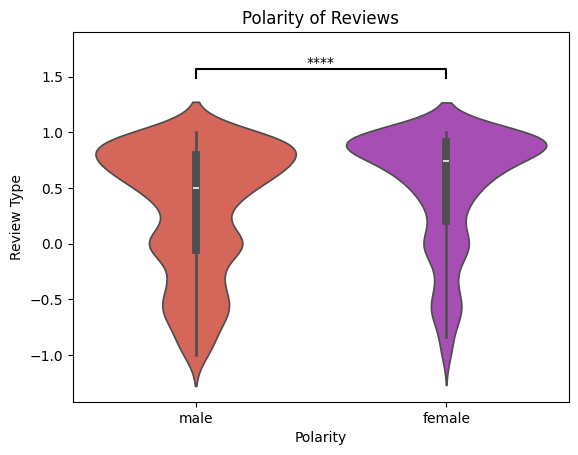

In [14]:
from scipy import stats
import starbars

malerevs = calc_sentiment(maleNeg) + calc_sentiment(malePos)
femalerevs = calc_sentiment(femaleNeg) + calc_sentiment(femalePos)

sigtest = stats.ks_2samp(malerevs,femalerevs)
pval = float(sigtest[1])

data = {
    'male': malerevs,
    'female': femalerevs,
}
sns.violinplot(
    data=data,
    palette = ["#ea5545", "#b33dc6"],
    orient="v",
    
).set(title="Polarity of Reviews", xlabel='Polarity', ylabel='Review Type')

annotations = [('male','female', pval)]
starbars.draw_annotation(annotations)

# Using the two-sample Kolmogorov-Smirnov test these two distributions are signifcantly different. 
# Of course due to small amounts of negative reviews I don't entirely trust these results

[Text(0.5, 1.0, 'Polarity of Reviews'),
 Text(0.5, 0, 'Polarity'),
 Text(0, 0.5, 'Review Type')]

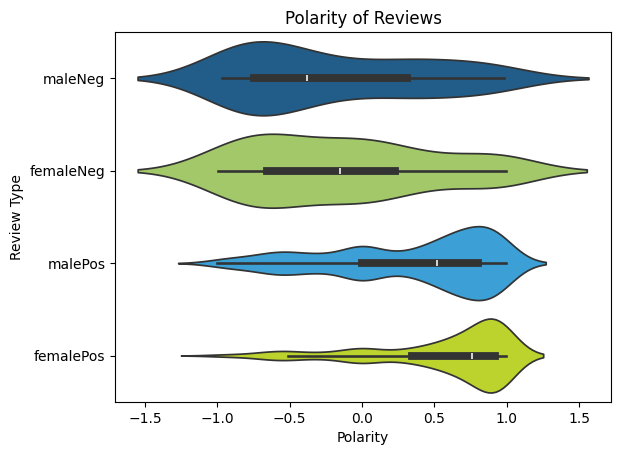

In [15]:
data = {
    'maleNeg': calc_sentiment(maleNeg),
    'femaleNeg': calc_sentiment(femaleNeg),
    'malePos': calc_sentiment(malePos),
    'femalePos': calc_sentiment(femalePos)
}

sns.violinplot(
    data=data,
    palette = ["#115f9a", "#a6d75b", "#22a7f0","#d0ee11"],
    orient="h",
    
).set(title="Polarity of Reviews", xlabel='Polarity', ylabel='Review Type')


# Looks like sentiment analysis generally seems to track with review type. 
# Seems to be pretty accurate for the reviews, perhaps some statistical tests are needed to prove this?

## Supervised Machine Learning
This one is more of a fun little side thing while I am waiting for topic modeling/LDA. I'm planning to essentially see how well a model can predict positive or negative reviews. The problem is my training data is incredibly small so this will be fairly inaccurate. Since my data is already labeled for me by an up or down vote then it's pretty straight forward to separate. I need to do a little more research on this though before I implement it. I'm considering using a model that incorporates all reviews and then separating out the female and male protagonist reviews to see if it affects the accuracy of the model. If it does that could indicate a difference between review types (or poor training). In short I've done some thinking about it but haven't implemented it yet.